<a href="https://colab.research.google.com/github/cehkop/Deep_learning_school_MIPT/blob/main/homework/dense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

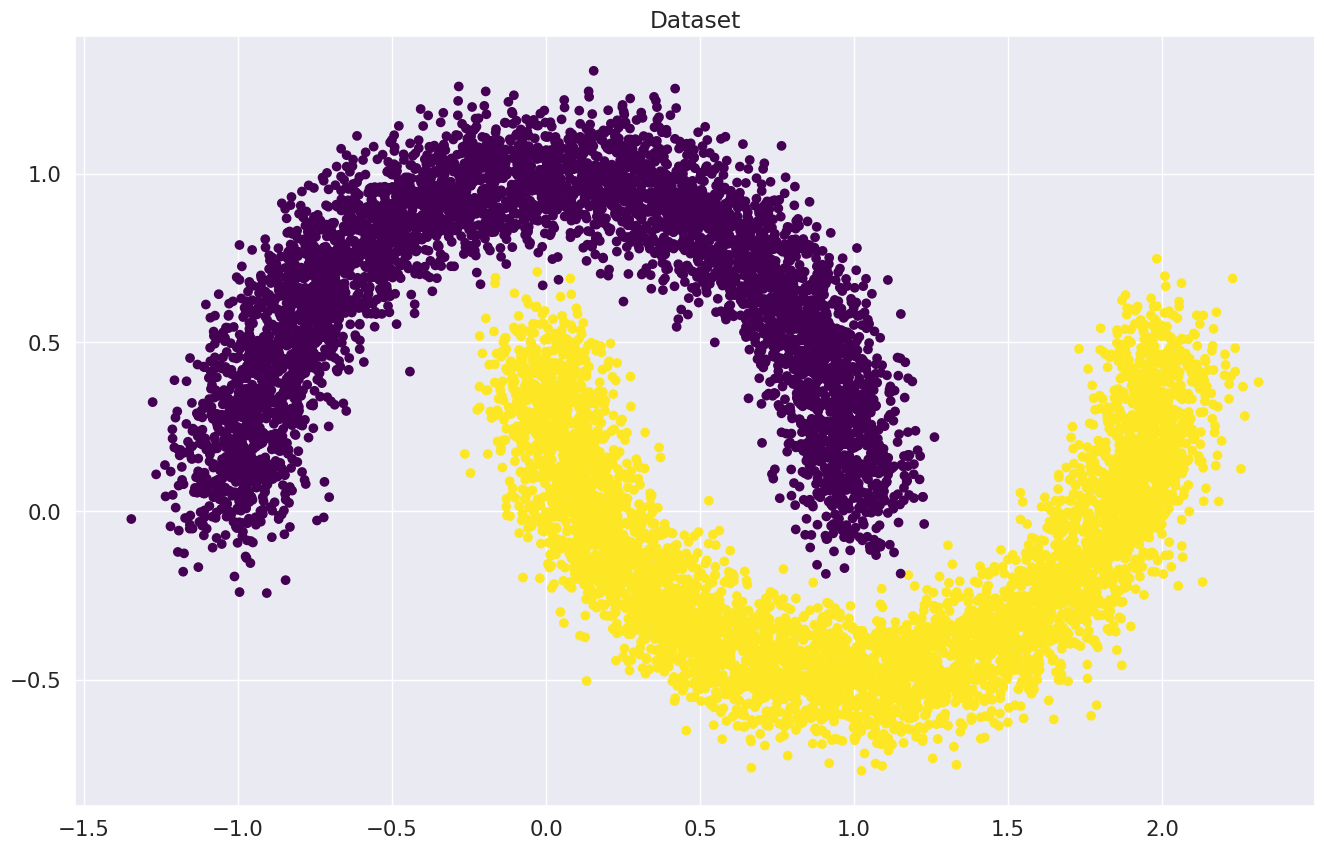

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train[:, None], dtype=torch.float32)
X_val_t =   torch.tensor(X_val, dtype=torch.float32)
y_val_t =   torch.tensor(y_val[:, None], dtype=torch.float32)

In [7]:
y_val_t.shape

torch.Size([2500, 1])

Создаем `Dataset` и `DataLoader`. 

In [8]:
batch_size=128
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, drop_last=True)

In [9]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 2]), torch.Size([128, 1]))

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [10]:
from torch import Tensor

class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, 
                                                out_features))
        self.weights.requires_grad_()
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))
            self.bias_term.requires_grad_()

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [11]:
model = LinearRegression(2, 1)

trainable_params  = sum(
    p.numel() for p in model.parameters() 
    if p.requires_grad
    )
print(f"Кол-во обучаемых параметров: {trainable_params}")

Кол-во обучаемых параметров: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [12]:
model = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(model.weights)
stop_it = False

print()


for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        y_pred =  model(X_batch)# Use linear_regression to get outputs

        loss = loss_function(y_pred, y_batch)# Compute loss
        loss.backward()

        losses.append(loss.detach().flatten()[0])
        optimizer.step()

        probabilities = torch.sigmoid(y_pred) # Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = model.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        
    if stop_it:
        break


Iteration: 0
Batch accuracy: 62.03125
Iteration: 100
Batch accuracy: 62.25
Iteration: 200
Batch accuracy: 63.875
Iteration: 300
Batch accuracy: 65.3125
Iteration: 400
Batch accuracy: 64.3125
Iteration: 500
Batch accuracy: 64.046875
Iteration: 600
Batch accuracy: 64.046875
Iteration: 700
Batch accuracy: 64.125

Iteration: 747.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: **

In [13]:
it + epoch * len(train_dataloader)

747

### Визуализируем результаты

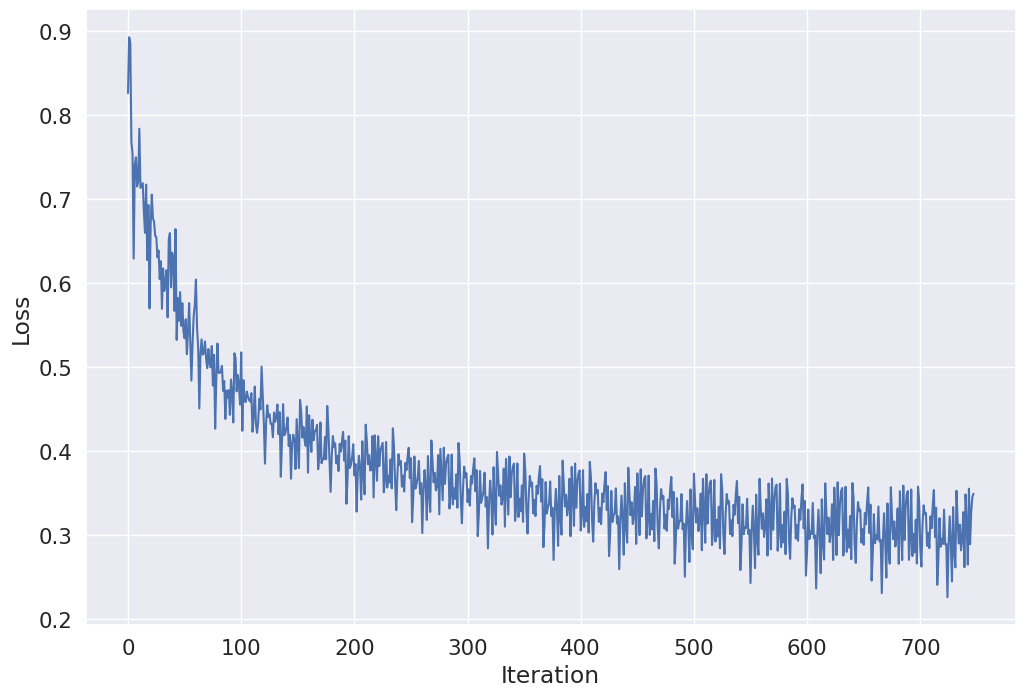

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

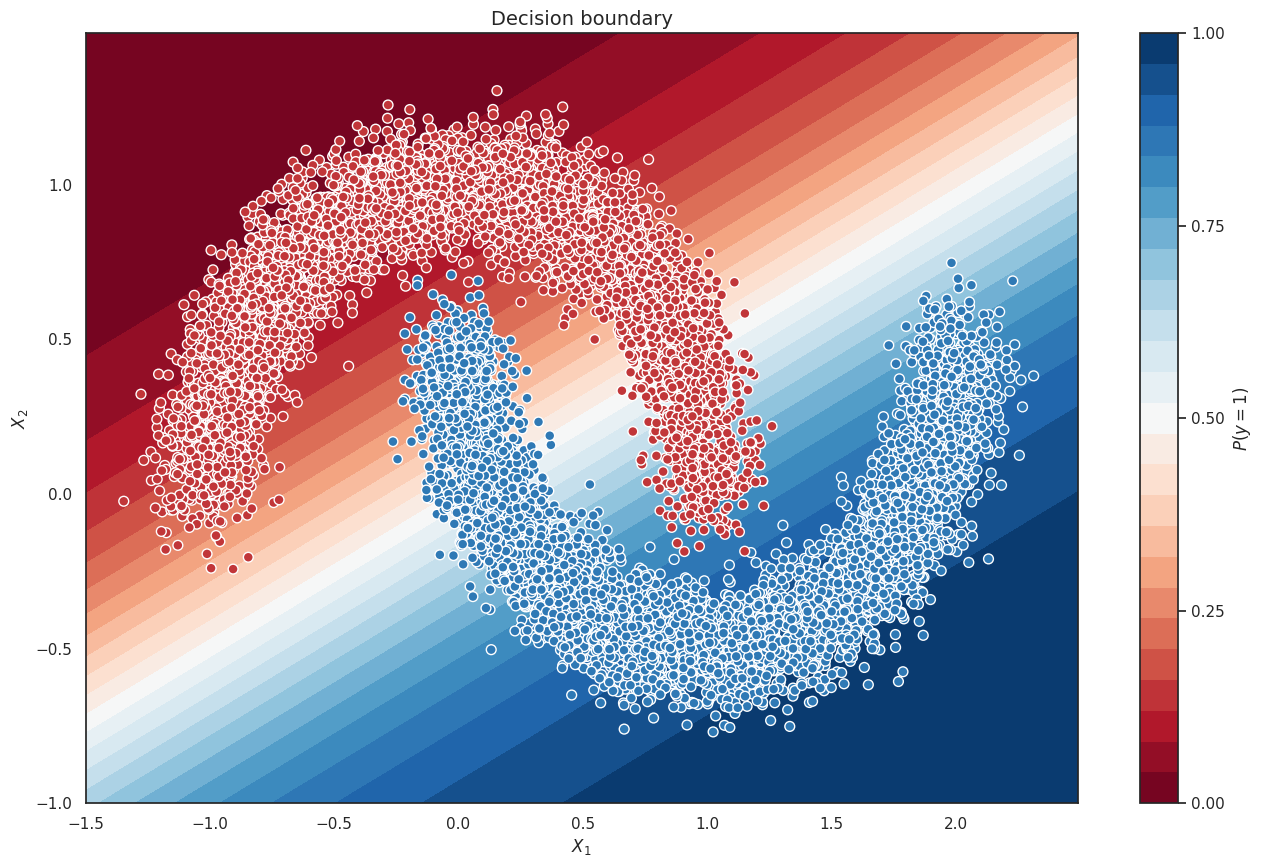

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(model(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch))# Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return np.round(predictions.flatten())

In [17]:
from sklearn.metrics import accuracy_score

y_pred = predict(dataloader = val_dataset, model = model)

# Compute total accuracy
accuracy_score(y_val, y_pred)

0.862

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: ** 

In [18]:
accuracy_score(y_val, y_pred)

0.862

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [19]:
# delete previous
del model
del optimizer
del train_dataloader
# del dataloader

In [20]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=128, drop_last=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [21]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [22]:
input = 784
ouput = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ELU(),
    nn.Linear(128, ouput),
    nn.Softmax()
)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=10, bias=True)
  (4): Softmax(dim=None)
)

In [23]:
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [24]:
from tqdm.notebook import tqdm

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":# Set model to ``train`` mode and calculate outputs
                model.train()
                optimizer.zero_grad()
            else:
                model.eval()

            y_pred = model(x_batch)
            preds = y_pred.argmax(-1)
            correct = sum((preds.cpu().detach() == y_batch).squeeze())
            epoch_correct += correct
            epoch_all += y_batch.size(dim=0)
            if k == "train": # Calculate gradients and make a step of optimizer
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1
Loader: train. Accuracy: 0.6385049223899841
Loader: valid. Accuracy: 0.7941706776618958
Epoch: 2
Loader: train. Accuracy: 0.8058560490608215
Loader: valid. Accuracy: 0.8227163553237915
Epoch: 3
Loader: train. Accuracy: 0.8201956748962402
Loader: valid. Accuracy: 0.8278245329856873
Epoch: 4
Loader: train. Accuracy: 0.8517628312110901
Loader: valid. Accuracy: 0.9089543223381042
Epoch: 5
Loader: train. Accuracy: 0.9051482081413269
Loader: valid. Accuracy: 0.9140625
Epoch: 6
Loader: train. Accuracy: 0.9096554517745972
Loader: valid. Accuracy: 0.9167668223381042
Epoch: 7
Loader: train. Accuracy: 0.9127938151359558
Loader: valid. Accuracy: 0.9184695482254028
Epoch: 8
Loader: train. Accuracy: 0.915481448173523
Loader: valid. Accuracy: 0.9201722741127014
Epoch: 9
Loader: train. Accuracy: 0.9178017973899841
Loader: valid. Accuracy: 0.9211738705635071
Epoch: 10
Loader: train. Accuracy: 0.9195045232772827
Loader: valid. Accuracy: 0.9223757982254028


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [25]:
def train_and_valid_change_activ(activation = nn.ELU(), epochs = 5):
    model[1].reset_parameters() # delete old weights
    model[2] = activation # change activ func
    model[3].reset_parameters() # delete old weights
    
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in tqdm(dataloader, leave = False):
                if k == "train":# Set model to ``train`` mode and calculate outputs
                    model.train()
                    optimizer.zero_grad()
                else:
                    model.eval()

                y_pred = model(x_batch)
                preds = y_pred.argmax(-1)
                correct = sum((preds.cpu().detach() == y_batch).squeeze())
                epoch_correct += correct
                epoch_all += y_batch.size(dim=0)
                if k == "train": # Calculate gradients and make a step of optimizer
                    loss = criterion(y_pred, y_batch)
                    loss.backward()
                    optimizer.step()

            accuracy[k].append((epoch_correct/epoch_all).numpy())

    return accuracy["valid"]

In [26]:
epochs = 5

plain_accuracy = train_and_valid_change_activ(activation = Identical(), epochs = epochs)
relu_accuracy = train_and_valid_change_activ(activation = nn.ReLU(), epochs = epochs)
elu_accuracy = train_and_valid_change_activ(epochs = epochs)
leaky_relu_accuracy = train_and_valid_change_activ(activation = nn.LeakyReLU(), epochs = epochs)
hardSw_accuracy = train_and_valid_change_activ(activation = nn.Hardswish(), epochs = epochs)
HardShrink_accuracy = train_and_valid_change_activ(activation = nn.Hardshrink(), epochs = epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [27]:
plain_accuracy

[array(0.8088942, dtype=float32),
 array(0.82522035, dtype=float32),
 array(0.8296274, dtype=float32),
 array(0.8327324, dtype=float32),
 array(0.8343349, dtype=float32)]

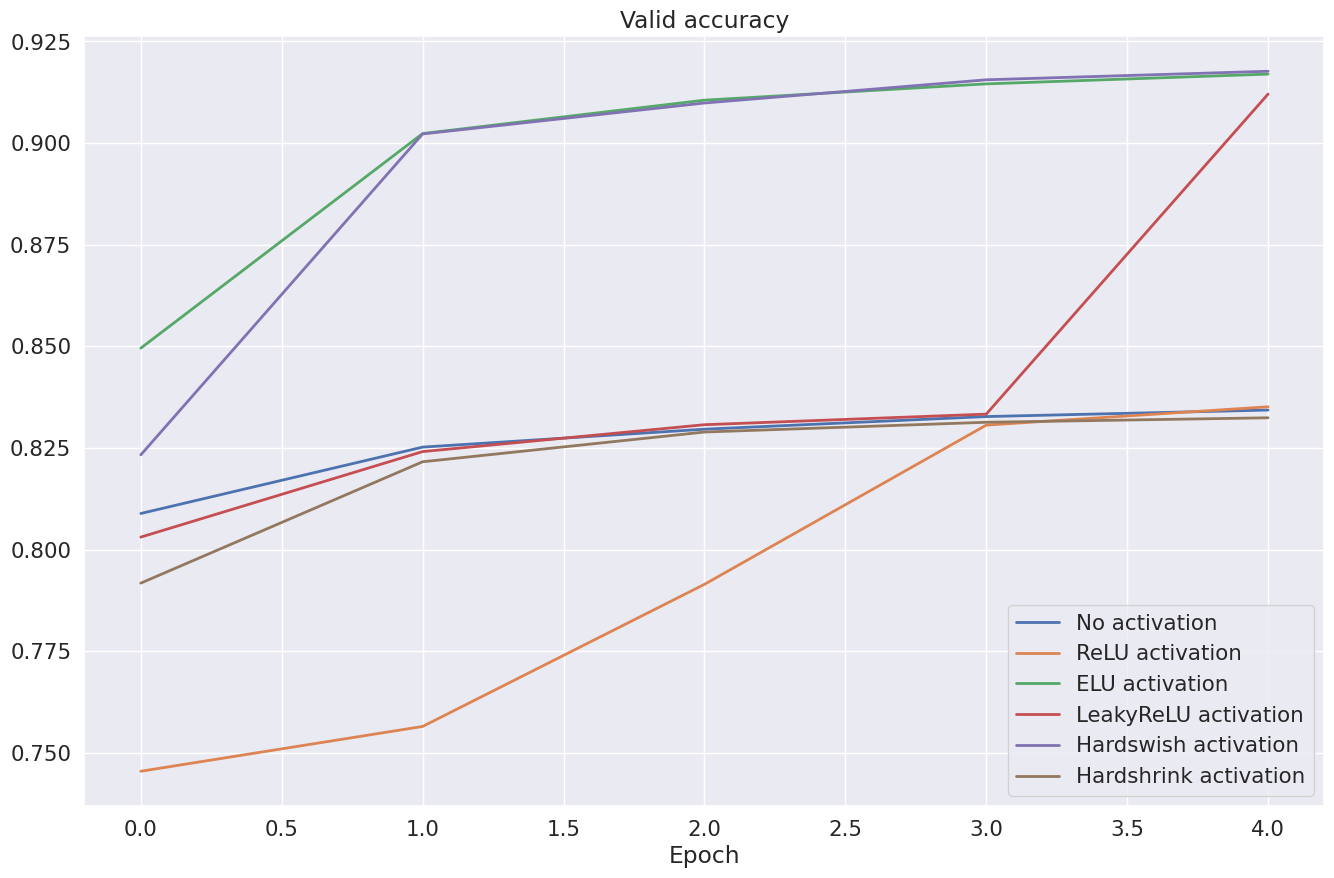

In [29]:
sns.set(style="darkgrid", font_scale=1.4)
max_epochs = 5
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), hardSw_accuracy, label="Hardswish activation", linewidth=2)
plt.plot(range(max_epochs), HardShrink_accuracy, label="Hardshrink activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [30]:
all_accuracy = {'plain': plain_accuracy[-1], 'relu' : relu_accuracy[-1], 
                "elu": elu_accuracy[-1],"leaky" : leaky_relu_accuracy[-1], 
                "hardSwish" : hardSw_accuracy[-1], "HardShrink" : HardShrink_accuracy[-1]}
    
max_acc = max(zip(all_accuracy.values(), all_accuracy.keys()))
# all_accuracy[max].key
print(f'Best is {max_acc[1]}, {max_acc[0]:.4f}')

Best is hardSwish, 0.9177


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [31]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-01 16:01:31--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-01 16:01:31--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 172.67.128.246, 104.21.1.92, 2606:4700:3036::ac43:80f6, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|172.67.128.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.001s  

2023-04-01 16:01:31

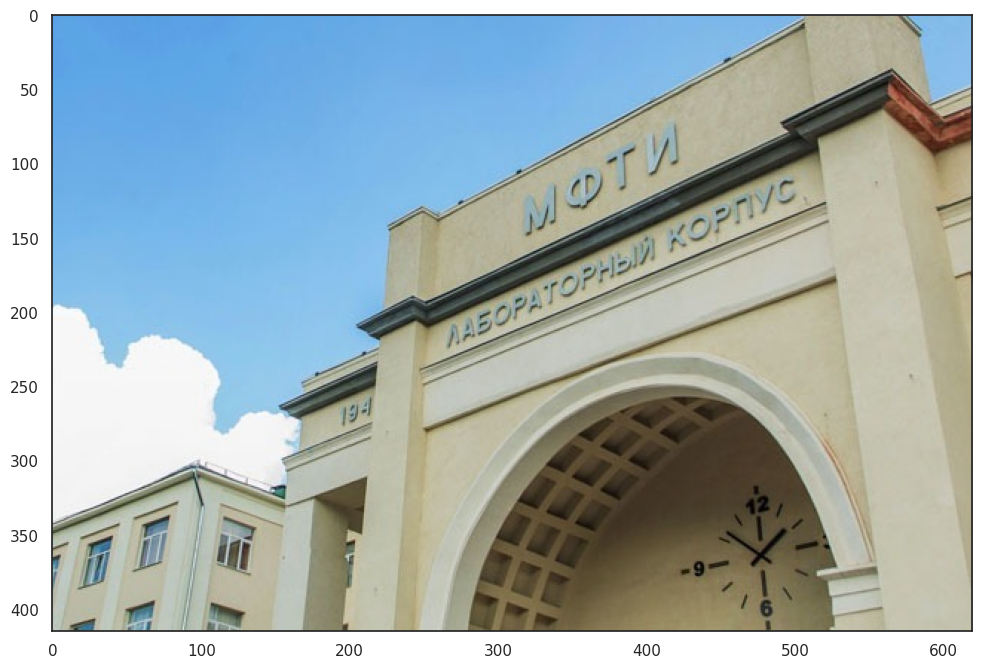

In [32]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

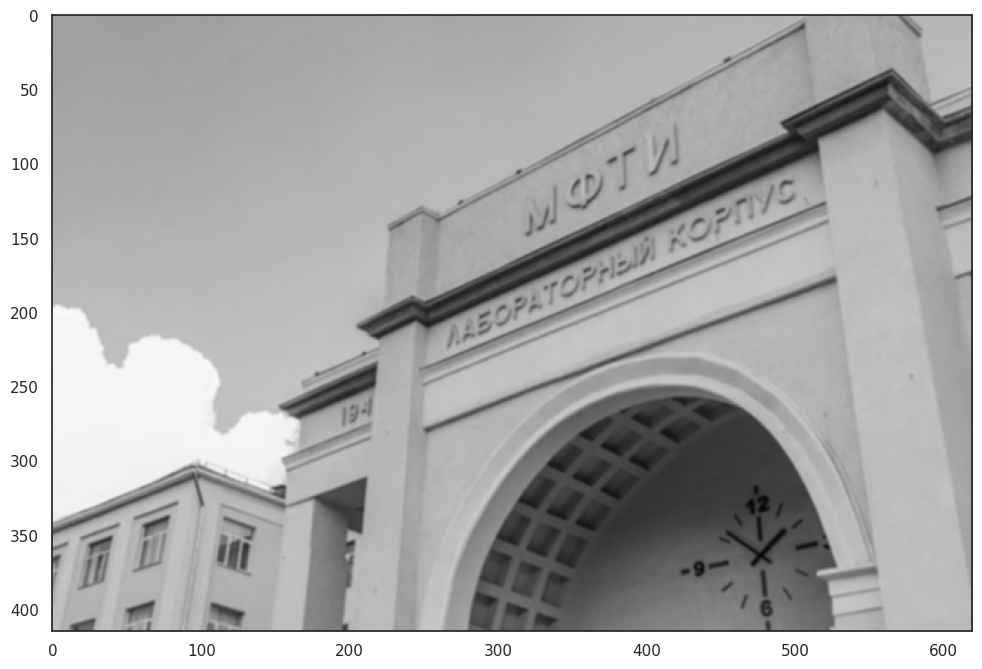

In [33]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

In [34]:
print('Размытие-Е\nУвел резк-Д\nТожд-A\nВерт гр-В\nГор гр-Б\nВсе гр-Г')

Размытие-Е
Увел резк-Д
Тожд-A
Верт гр-В
Гор гр-Б
Все гр-Г


### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [35]:
del model

In [36]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [38]:
epochs = 5

accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":# Set model to ``train`` mode and calculate outputs
                model.train()
                optimizer.zero_grad()
            else:
                model.eval()

            y_pred = model(x_batch)
            preds = y_pred.argmax(-1)
            correct = sum((preds.cpu().detach() == y_batch).squeeze())
            epoch_correct += correct
            epoch_all += y_batch.size(dim=0)
            if k == "train": # Calculate gradients and make a step of optimizer
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        accuracy[k].append((epoch_correct/epoch_all).numpy())

  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

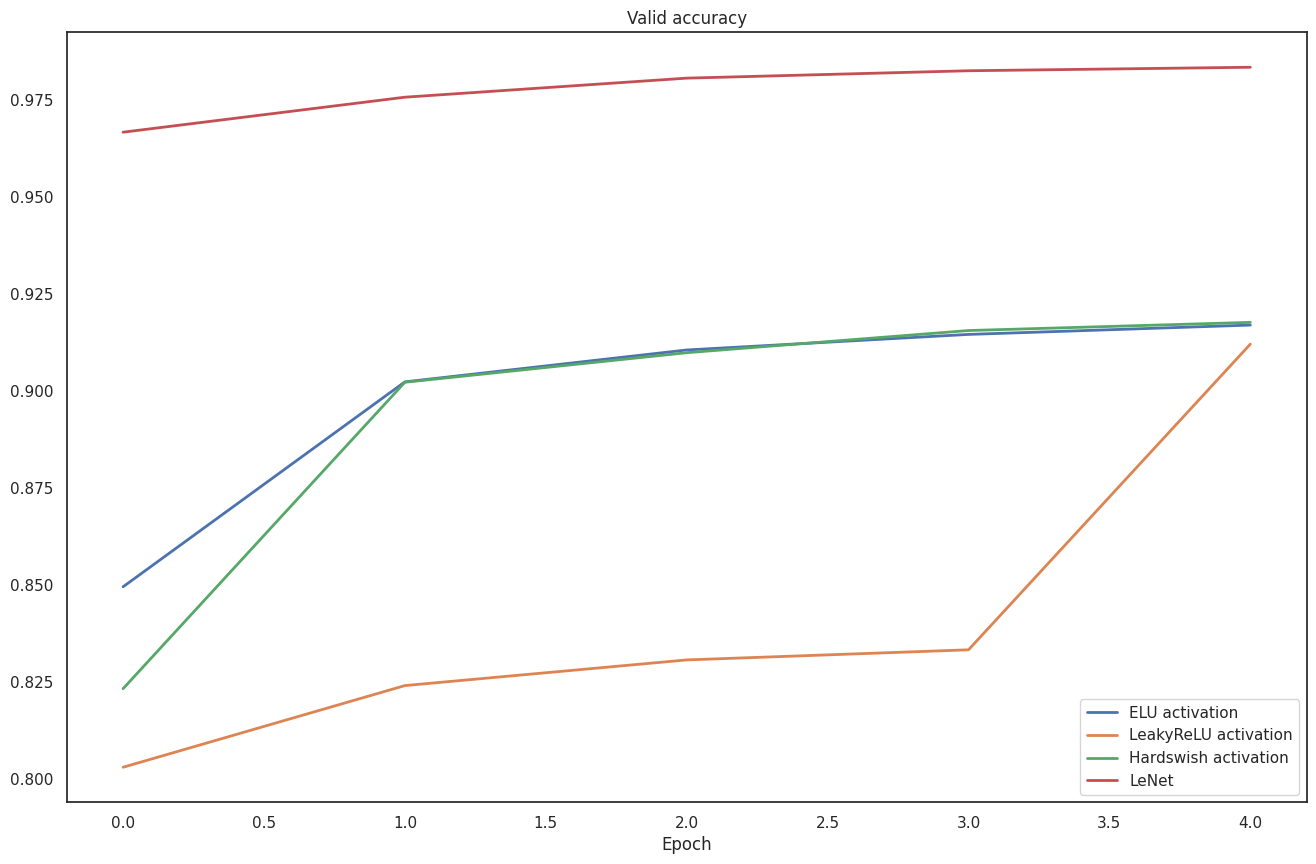

In [40]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), hardSw_accuracy, label="Hardswish activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [41]:
print(f'После {epochs} эпох обучения, точность достигла {lenet_accuracy[-1]:.3f}')

После 5 эпох обучения, точность достигла 0.983
